In [1]:
from pathlib import Path
import pandas as pd
from PIL import Image

DATA = Path("/kaggle/input/histopathologic-cancer-detection")
WORK = Path("/kaggle/working")

print("DATA mounted?", DATA.exists())
print("labels present?", (DATA/"train_labels.csv").exists())

# List a few files
!ls -lah /kaggle/input/histopathologic-cancer-detection | head -n 10

# Load labels and look at class balance
labels = pd.read_csv(DATA/"train_labels.csv")
display(labels.head(), labels['label'].value_counts(normalize=True))

# Show one image to confirm reading
sample_id = labels.iloc[0].id
img = Image.open(DATA/"train"/f"{sample_id}.tif")
img.size, img.mode


DATA mounted? True
labels present? True
total 12M
drwxr-xr-x 4 nobody nogroup    0 Aug 17 12:07 .
drwxr-xr-x 3 root   root    4.0K Aug 25 23:57 ..
-rwxr-xr-x 1 nobody nogroup 2.4M Dec 12  2019 sample_submission.csv
drwxr-xr-x 2 nobody nogroup    0 Aug 17 12:17 test
drwxr-xr-x 2 nobody nogroup    0 Aug 17 12:22 train
-rwxr-xr-x 1 nobody nogroup 9.1M Dec 12  2019 train_labels.csv


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

((96, 96), 'RGB')

In [2]:
# STEP 1: stratified train/validation split
from sklearn.model_selection import train_test_split

VAL_FRAC = 0.10
RANDOM_STATE = 42

train_df, val_df = train_test_split(
    labels,
    test_size=VAL_FRAC,
    stratify=labels['label'],
    random_state=RANDOM_STATE
)

print("train size:", len(train_df))
print("val size  :", len(val_df))
print("val positive rate:", val_df['label'].mean())
train_df.head()


train size: 198022
val size  : 22003
val positive rate: 0.40503567695314274


,id,label
29031,730b42edf8f14f730fcd9ac98fdc43e45e47a5b9,1
55490,efd3cfafc4a6a99176a9b6cdd69d02b85c8f2be5,0
47145,1182d726342f5e2054ab0926d2eb27f3f9a6d219,1
118906,7ca88efacbe747a6c5a6144b75ae082eb20833ab,1
112294,a44ece5a33090ad2c7b4c9a08b776206d7444fab,0


In [4]:
# REBUILD DATASET PIPELINE (PIL-based TIFF reader)
import tensorflow as tf
import numpy as np
from PIL import Image

IMG_SIZE = 96
BATCH    = 128
AUTO     = tf.data.AUTOTUNE

def _read_tiff(path_bytes):
    path = path_bytes.decode("utf-8")
    img  = Image.open(path)
    img  = img.resize((IMG_SIZE, IMG_SIZE))
    arr  = np.array(img, dtype=np.float32)
    if arr.ndim == 2:                      # grayscale fallback
        arr = np.stack([arr]*3, axis=-1)
    arr /= 255.0
    return arr

def decode_with_pil(path):
    img = tf.numpy_function(_read_tiff, [path], tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))  # static shape for TF
    return img

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img, label

def make_ds(df, training=True):
    paths  = (DATA/"train").as_posix() + "/" + df["id"].astype(str) + ".tif"
    labels = df["label"].astype("float32").values
    ds = tf.data.Dataset.from_tensor_slices((paths.values, labels))
    ds = ds.map(lambda p,l: (decode_with_pil(p), l), num_parallel_calls=AUTO)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTO).shuffle(8192)
    ds = ds.batch(BATCH).prefetch(AUTO)
    return ds

ds_train = make_ds(train_df, training=True)
ds_val   = make_ds(val_df,   training=False)

# quick sanity check: shapes and value range
xb, yb = next(iter(ds_train))
xb.shape, yb.shape, (float(tf.reduce_min(xb)), float(tf.reduce_max(xb)))


(TensorShape([128, 96, 96, 3]), TensorShape([128]), (0.0, 1.0))

In [5]:
from tensorflow.keras import layers as L, models, callbacks, optimizers, metrics
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def make_model():
    inputs = L.Input((IMG_SIZE, IMG_SIZE, 3))
    x = L.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = L.MaxPool2D()(x)
    x = L.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = L.MaxPool2D()(x)
    x = L.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(0.3)(x)
    outputs = L.Dense(1, activation='sigmoid')(x)
    m = models.Model(inputs, outputs)
    m.compile(
        optimizer=optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[metrics.AUC(name='AUC')]
    )
    return m

cw = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_df['label'].values
)
class_weights = {0: float(cw[0]), 1: float(cw[1])}

model = make_model()
cbs = [
    callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_AUC', mode='max'),
    callbacks.ModelCheckpoint('/kaggle/working/best.keras', save_best_only=True, monitor='val_AUC', mode='max')
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    class_weight=class_weights,
    callbacks=cbs
)


Epoch 1/10
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 2343s 2s/step - AUC: 0.8241 - loss: 0.5101 - val_AUC: 0.8928 - val_loss: 0.4415
Epoch 2/10
 362/1548 ━━━━━━━━━━━━━━━━━━━━ 29:22 1s/step - AUC: 0.8855 - loss: 0.4264

KeyboardInterrupt: 

In [6]:
from pathlib import Path
import tensorflow as tf, pandas as pd
from tensorflow.keras.models import load_model

# load best checkpoint (save current model if the file isn't there for any reason)
ckpt_path = Path('/kaggle/working/best.keras')
if not ckpt_path.exists():
    model.save(ckpt_path)
best = load_model(ckpt_path, compile=False)

# build test dataset (uses the decode_with_pil defined earlier)
test_ids = sorted([p.stem for p in (DATA/'test').glob('*.tif')])

def make_test_ds(ids):
    paths = [str(DATA/'test'/f'{i}.tif') for i in ids]
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(lambda p: decode_with_pil(p), num_parallel_calls=AUTO)
    return ds.batch(BATCH).prefetch(AUTO)

ds_test = make_test_ds(test_ids)
probs = best.predict(ds_test, verbose=1).ravel()

sub = pd.DataFrame({'id': test_ids, 'label': probs})
sub_path = '/kaggle/working/submission.csv'
sub.to_csv(sub_path, index=False)
sub.head(), sub_path


449/449 ━━━━━━━━━━━━━━━━━━━━ 268s 596ms/step


(                                         id     label
 0  00006537328c33e284c973d7b39d340809f7271b  0.761379
 1  0000ec92553fda4ce39889f9226ace43cae3364e  0.718092
 2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.531973
 3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.485985
 4  000270442cc15af719583a8172c87cd2bd9c7746  0.067919,
 '/kaggle/working/submission.csv')

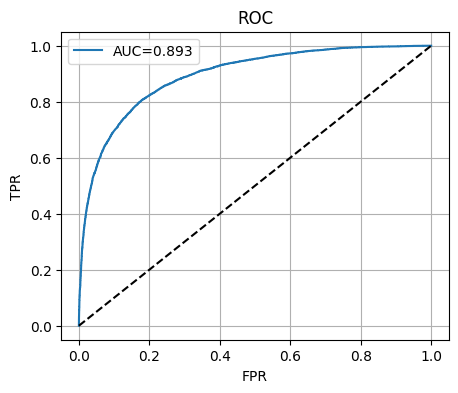

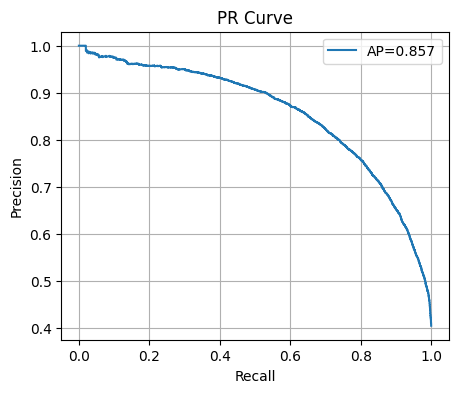

AUC: 0.893 AP: 0.857 Thr: 0.576
Confusion matrix:
 [[10761  2330]
 [ 1736  7176]]
              precision    recall  f1-score   support

           0      0.861     0.822     0.841     13091
           1      0.755     0.805     0.779      8912

    accuracy                          0.815     22003
   macro avg      0.808     0.814     0.810     22003
weighted avg      0.818     0.815     0.816     22003



In [7]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

best = load_model('/kaggle/working/best.keras', compile=False)

val_probs = best.predict(ds_val, verbose=0).ravel()
val_true  = val_df['label'].values

auc = roc_auc_score(val_true, val_probs)
fpr, tpr, _ = roc_curve(val_true, val_probs)
plt.figure(figsize=(5,4)); plt.plot(fpr,tpr,label=f'AUC={auc:.3f}'); plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(); plt.grid(True); plt.savefig('/kaggle/working/roc.png',dpi=150); plt.show()

prec, rec, thr = precision_recall_curve(val_true, val_probs)
ap = average_precision_score(val_true, val_probs)
plt.figure(figsize=(5,4)); plt.plot(rec,prec,label=f'AP={ap:.3f}'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.legend(); plt.grid(True); plt.savefig('/kaggle/working/pr.png',dpi=150); plt.show()

f1 = 2*prec*rec/(prec+rec+1e-9); best_idx = np.argmax(f1[:-1]); best_thr = thr[best_idx]
pred = (val_probs >= best_thr).astype(int)
print("AUC:", round(auc,3), "AP:", round(ap,3), "Thr:", round(float(best_thr),3))
print("Confusion matrix:\n", confusion_matrix(val_true, pred))
print(classification_report(val_true, pred, digits=3))


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score

thr_default = 0.50
pred_050 = (val_probs >= thr_default).astype(int)

def brief_scores(y_true, y_pred):
    return {
        "F1": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred)
    }

print("Scores @ 0.50:", brief_scores(val_true, pred_050))
print("Scores @ best threshold:", brief_scores(val_true, pred))

print("\nConfusion @ 0.50\n", confusion_matrix(val_true, pred_050))
print("\nConfusion @ best threshold\n", confusion_matrix(val_true, pred))


Scores @ 0.50: {'F1': 0.7755165449743671, 'Precision': 0.7200692374266756, 'Recall': 0.8402154398563735, 'Accuracy': 0.8029814116256874}
Scores @ best threshold: {'F1': 0.7792377022478012, 'Precision': 0.7548916473806018, 'Recall': 0.8052064631956912, 'Accuracy': 0.8152070172249238}

Confusion @ 0.50
 [[10180  2911]
 [ 1424  7488]]

Confusion @ best threshold
 [[10761  2330]
 [ 1736  7176]]


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session